# Introducing molecular dynamics

This hands-on workshop introduces the basic concepts of HOOMD-blue and will teach you how to run a molecular dynamics simulation. For more details, information that may be helpful when completing the exercises, see the [HOOMD-blue documentation](https://hoomd-blue.readthedocs.io/).

**Google Colab users:** Click the "Copy to Drive" button in the toolbar to save this notebook and any edits that you make to your Google Drive.

## Overview MD workflow 

![MD Workflow](https://drive.google.com/uc?id=1G5VqK-sIQHw0vhawX6dmMcNYYKQFx_B_)


## Utility code

Please ignore the content of these cells, they provide some helpful methods but are not part of the workshop.

Run them one at a time, then click the arrow by "Utility code" to hide them.



In [1]:
# This cell installs HOOMD-blue in Google Colab.
try:
    import google

    !pip install -q condacolab
    import condacolab

    condacolab.install_from_url(
        'https://github.com/glotzerlab/hoomd-workshop/releases/download/2023.1.0/hoomd-workshop-2023.1.0-Linux-x86_64.sh'
    )
except ModuleNotFoundError:
    pass

✨🍰✨ Everything looks OK!


In [2]:
import gsd.hoomd
import hoomd
import IPython
import packaging.version
import PIL
import matplotlib
import matplotlib.pyplot as plt
import numpy
import math
import warnings
import fresnel
import itertools 
import io 
import freud 
import io
import warnings


device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=400, h=400)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    Lx = snapshot.configuration.box[0]
    Ly = snapshot.configuration.box[1]
    Lz = snapshot.configuration.box[2]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04

    if (hasattr(snapshot, 'log')
            and 'particles/md/pair/LJ/energies' in snapshot.log):
        energies = snapshot.log['particles/md/pair/LJ/energies']
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=numpy.min(energies),
                                             vmax=numpy.max(energies),
                                             clip=True),
            cmap=matplotlib.cm.get_cmap(name='viridis'))
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(energies))
        geometry.material.primitive_color_mix = 1
    
    else:
        
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=-0.5,
                                              vmax=1,
                                              clip=True),
            cmap=matplotlib.cm.get_cmap(name='RdYlBu'))
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(snapshot.particles.typeid))
        geometry.material.primitive_color_mix = 1

    box = fresnel.geometry.Box(scene, [Lx, Ly, Lz, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(Lx * 2, Ly, Lz * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=Lx * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=20)

def render_image(snapshot):
  a = render(snapshot)
  return IPython.display.Image(a._repr_png_())

def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render(frames[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert("P")
       # "P", palette=PIL.Image.Palette.ADAPTIVE)
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f)
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if (size > 3000):
        warnings.warn(f"Large GIF: {size} KiB")
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))
 
warnings.filterwarnings('ignore', module='hoomd')
warnings.filterwarnings('ignore', module='numpy')

## Create the simulation and initial state

Just like we did with HPMC.

In [3]:
cpu = hoomd.device.CPU()
#gpu = hoomd.device.GPU()
sim = hoomd.Simulation(device=cpu, seed=2)

Here we set up the initial positions and box (i.e., "start"):

total number of particles 300
Box length 9.99985
Overall number density 0.30001350040501007


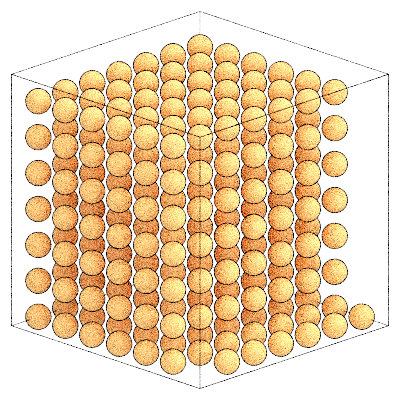

In [18]:
snapshot = hoomd.Snapshot()

N_particles = 300
spacing = 1.42855
K = math.ceil(N_particles**(1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)

positions = list(itertools.product(x, repeat=3))
box= [L,L,L,0,0,0]

snapshot = gsd.hoomd.Snapshot()
snapshot.configuration.box = [L, L, L, 0, 0, 0]
snapshot.particles.N = N_particles
snapshot.particles.position = positions[:N_particles]
snapshot.particles.types = ['A']
snapshot.particles.typeid = [0] * N_particles

print("total number of particles",N_particles)
print("Box length",L)
print("Overall number density",N_particles/(L**3))
render_image(snapshot)

## Periodic boundary conditions 

An essential question for MD simulations is: What happens at the border of the box? The default choice is to implement something called [periodic boundary conditions](https://en.wikipedia.org/wiki/Periodic_boundary_conditions). They are often chosen for approximating a large (infinite) system by using a small part, i.e., the simulation box. Here, a particle that is leaving the box at one end, is "folded back" into the box at the other end:

<img src="https://drive.google.com/uc?id=10sIVRb0UuvgyS_mWaZqZ-FEz8Y1eYkv6" width="400">

Alternatively, one can think of this as an array of "copied" or "tiled" boxes:

<img src="https://drive.google.com/uc?id=1ohz1THbjy1sP_t5UgyTdTngn0GF3RPxa" width="400">

([image source](https://isaacs.sourceforge.net/phys/pbc.html))

The large systems approximated by PBCs consist of an infinite number of simulation boxes. In computer simulations, one of these is the "original" simulation box, and others are copies called images. During the simulation, only the properties of the original simulation box need to be recorded and propagated. The "minimum-image convention" is a common form of PBC particle bookkeeping in which each individual particle in the simulation interacts with the closest image of the remaining particles in the system, $r= |\mathrm{minimum\_image}(\vec{r}_k - \vec{r}_j)|$.

In [19]:
sim.create_state_from_snapshot(snapshot)

## Molecular dynamics classes

In molecular dynamics simulations, HOOMD-blue numerically integrates the degrees of freedom in the system as a function of time under the influence of forces (i.e. "integrate" and "move" ). To perform MD simulations, assign a [MD integrator](https://hoomd-blue.readthedocs.io/en/latest/package-md.html#hoomd.md.Integrator) to the `hoomd.Simulation` operations. Provide the Integrator with lists of integration methods, forces, and constraints to apply during the integration. See [Hoomd-blue documentation](https://hoomd-blue.readthedocs.io/en/latest/module-md-methods.html) on MD methods for more information on hoomd capabilities. 


MD updaters (`hoomd.md.update`) perform additional operations during the simulation, including rotational diffusion and establishing shear flow. Use MD computes (`hoomd.md.compute`) to compute the thermodynamic properties of the system state.

## Velocity Verlet 
For nummerically integrating Hoomd-blue uses the [velocity Verlet algorithm](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet). In velocity Verlet, we keep track of one vector of position and one vector of velocity. The standard implementation scheme of this algorithm is:

1. Calculate: ${\vec {v} \left(t+{\tfrac {1}{2}}\,\Delta t\right)=\vec {v} (t)+{\tfrac {1}{2}}\,\vec {a} (t)\,\Delta t}.$

2. Calculate: ${ \vec {x} (t+\Delta t)=\vec {x} (t)+\vec {v} \left(t+{\tfrac {1}{2}}\,\Delta t\right)\,\Delta t}.$
3. Derive ${\ \vec {a} (t+\Delta t)}$ from the interaction potentials using ${\vec {x} (t+\Delta t)}$.
4. Calculate: ${\vec {v} (t+\Delta t)=\vec {v} \left(t+{\tfrac {1}{2}}\,\Delta t\right)+{\tfrac {1}{2}}\,\vec {a} (t+\Delta t)\Delta t}.$



In [20]:
integrator = hoomd.md.Integrator(dt=0.005)

You need a neighbor list to compte pairwise interactions:

In [21]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

Compute Lennard-Jones interaction forces:
$$V_{\mathrm{LJ}}(r) = 4 \varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]$$

See [Hoomd-blue documentation](https://hoomd-blue.readthedocs.io/en/latest/module-md-pair.html#hoomd.md.pair.LJ) on LJ interactions, and the documentation of `hoomd.md.pair`  for a [list](https://hoomd-blue.readthedocs.io/en/latest/module-md-pair.html) of all availaibe particle pair interactions.

In [40]:
lj = hoomd.md.pair.LJ(nlist=cell,mode='shift')
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)

Set `r_cut` to 2.5:

In [41]:
lj.r_cut[('A', 'A')] = 2.5

While pair potentials are nominally defined between all pairs of particles, Molecular dynamics simulations evaluate short ranged pair potentials only for 
$r<r_\mathrm{cut}$ to make the computation fast through the use of a neighbor list. By default, HOOMD-blue introduces a discontinuity in $V$ at $r=r_\mathrm{cut}$, though there are options to shift or smooth the potential at the cutoff.
The force is given by:

\begin{split}\vec{F} =
\begin{cases}
-\nabla V_\mathrm{LJ}(r) & r < r_{\mathrm{cut}} \\
0 & r \ge r_{\mathrm{cut}} \\
\end{cases}\end{split}

Let's plot the potential and force:

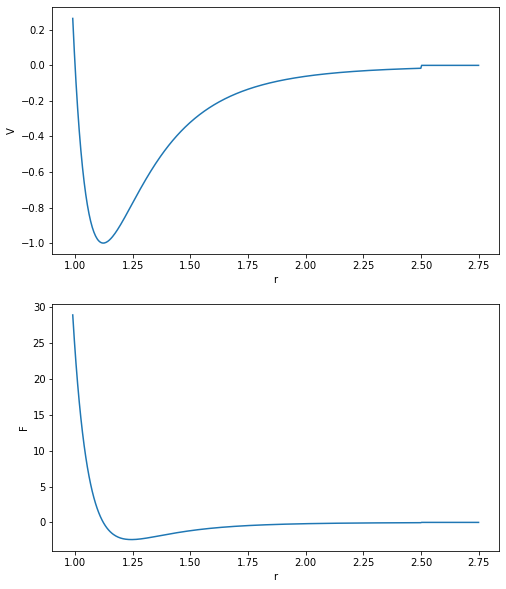

In [42]:
sigma = 1
epsilon = 1
r_cut = 2.5 

r = numpy.linspace(0.99, 2.75, 500)
V_lj = numpy.piecewise( r, [r< r_cut,r>=r_cut],[lambda x: 4 * epsilon * ((sigma / x)**12 - (sigma / x)**6),0])
F_lj = numpy.piecewise( r, [r< r_cut,r>=r_cut],[lambda x: - 24 * epsilon * sigma**6 / x**7 + (48 * epsilon * sigma**12 / x**13),0])


fig, ax = plt.subplots(2,figsize=(8,10))
ax[0].plot(r, V_lj)
ax[0].set_xlabel('r')
ax[0].set_ylabel('V')

ax[1].plot(r, F_lj)
ax[1].set_xlabel('r')
ax[1].set_ylabel('F');

## Neighbor lists 

[Neighbor lists](https://hoomd-blue.readthedocs.io/en/latest/module-md-nlist.html) help speed up MD simulations significantly. As we have seen, pair interactions are cut off at some distance $r_{cut}$, meaning that not all distances between all particles have to be calculated, instead, a neighbor list can bookkeep all potential interacting particles based on, for example, a cell list grid:

<img src="https://drive.google.com/uc?id=1VePxgp67ZtUKegnC-oZ2tuxZEYJUSHYg" width="500">



Add the `lj` force to the integrator's `forces` list:

In [43]:
integrator.forces.append(lj)

The integration **method** sets the specific equations of motion that apply to a subset of particles:

In [44]:
all_particles = hoomd.filter.All()
kT = 1.5
nvt = hoomd.md.methods.NVT(kT=kT, filter=all_particles, tau=0.5)

## Thermostat 

We use the [Nose Hoover thermostat](https://hoomd-blue.readthedocs.io/en/latest/module-md-methods.html#hoomd.md.methods.NVT) to keep the temperature fluctuating around the setpoint (consistent with the expected thermal fluctuations). It enables  simulations in the canonical (NVT) ensemble by coupling the system to a heat bath. The system Hamiltonian is extended by introducing a thermal reservoir and a friction term in the equations of motion. The friction force is proportional to the product of each particle’s velocity and a friction parameter, $\xi$. This friction parameter (or heat bath variable) is a fully dynamic quantity with its own momentum $p_{\xi}$ and equation of motion; the time derivative is calculated from the difference between the current kinetic energy and the reference temperature. 

In this formulation, the particles´ equations of motion in the global MD scheme are replaced by:

$\frac {{\mbox{d}}^2\mathbf{r}_i}{{\mbox{d}}t^2} = \frac{\mathbf{F}_i}{m_i} -
\frac{p_{\xi}}{Q}\frac{{\mbox{d}}\mathbf{r}_i}{{\mbox{d}}t} ,$
 
 
where the equation of motion for the heat bath parameter 
 is:

$\frac {{\mbox{d}}p_{\xi}}{{\mbox{d}}t} = \left( T - T_0 \right)$.
 
The reference temperature is denoted $T_0$
, while $T$ is the current instantaneous temperature of the system. The strength of the coupling is determined by the constant $Q$
 (usually called the mass parameter of the reservoir) in combination with the reference temperature. The coupling parameter is specified via

 $Q = \frac {\tau^2 T_0}{4 \pi^2}.$

 Hoomd-blue uses the equations of motion using the symplectic Martyna-Tobias-Klein formalism described in  [G. J. Martyna, D. J. Tobias, M. L. Klein 1994](https://aip.scitation.org/doi/10.1063/1.467468) and [J. Cao, G. J. Martyna 1996](https://aip.scitation.org/doi/10.1063/1.470959).

Add `nvt` to the integrator's `methods` list:

In [45]:
integrator.methods.append(nvt)

Remember to add the integrator to the simulation operations!

In [46]:
sim.operations += integrator

## Running a molecular dynamics simulation

HOOMD-blue defaults particle velocities to 0:

In [47]:
print(sim.state.get_snapshot().particles.velocity[0:5, :])

[[ 0.27308054 -1.38370307  0.87664638]
 [-0.0728648   0.24753766 -1.07795222]
 [ 0.2558663   0.81072793  0.43089947]
 [ 0.99374312  1.09423675  0.58594488]
 [ 0.0652508  -0.91741277  0.37131265]]


Thermalize the velocities and integration method's degrees of freedom before running. We use the Maxwell-Boltzmann distribution at a given temperature $T$,

$p(v_i) = \sqrt{\frac{m_i}{2 \pi kT}}\exp\left(-\frac{m_i v_i^2}{2kT}\right)$

where $k$ is Boltzmann’s constant:

In [48]:
sim.state.thermalize_particle_momenta(filter=all_particles, kT=kT)
sim.run(0)
print(sim.state.get_snapshot().particles.velocity[0:5, :])

[[ 0.1199307   1.0706968  -1.02096025]
 [-0.43070169  0.02073303  2.46980332]
 [-0.42377449 -1.82072277  1.37045202]
 [ 2.04871378  1.13254196  2.53220284]
 [ 1.88954501  0.40300322 -0.15523694]]


## Querying thermodynamic quantities

The `ThermodynamicQuantities` class computes properties of the simulation:

In [49]:
thermo = hoomd.md.compute.ThermodynamicQuantities(filter=all_particles)
sim.operations += thermo

Use `thermo` to get the `kinetic_temperature` of the system, i.e. the instantaneous kinetic temperature:   $kT_k = 2 \cdot \frac{K}{N_{\mathrm{dof}}}$, where $K$ is the kinetic energy: $K  = {\frac{1}{2}}\sum_{i=1}^N m_i v_i^2$.

In [50]:
print("kT",thermo.kinetic_temperature)
#print("potential energy",thermo.potential_energy)
#print("kinetic energy",thermo.kinetic_energy)

kT 0.7342065987509525


## Logging scalar quantities

Use a Logger to monitor how properties of the simulation vary during the run:

In [51]:
logger = hoomd.logging.Logger(categories=['scalar'])

Choose the specific quantities you want to log:

In [52]:
logger.add(sim,quantities=['timestep'])
logger.add(thermo, quantities=['potential_energy','kinetic_energy','kinetic_temperature','pressure'])
#thermo.loggables

Use the `Table` writer to display the logged values:

In [53]:
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(1000),
                          logger=logger,
                          max_header_len=5,
                          max_precision=2)
sim.operations += table

We can also save it to a file: 

In [54]:
file = open('log.txt', mode='w')
table_file = hoomd.write.Table(output=file,
                               trigger=hoomd.trigger.Periodic(10),
                               logger=logger)
sim.operations +=table_file


Now run the simulation for `1000` timesteps.

In [55]:
sim.run(50000)

  51000      -1234.71943      705.62310          0.78403        -0.28128 
 timestep  potential_energy kinetic_energy kinetic_temperature  pressure 
  51000      -1234.71943      705.62310          0.78403        -0.28128 
  52000      -1164.14435      805.00703          0.89445        -0.15473 
  52000      -1164.14435      805.00703          0.89445        -0.15473 
  53000       -992.25847      1184.26991         1.31586        0.62983  
  53000       -992.25847      1184.26991         1.31586        0.62983  
  54000       -965.01440      1520.73591         1.68971        0.79709  
  54000       -965.01440      1520.73591         1.68971        0.79709  
  55000      -1012.28963      1856.05383         2.06228        0.96607  
  55000      -1012.28963      1856.05383         2.06228        0.96607  
  56000      -1033.59646      1956.02890         2.17337        1.05060  
  56000      -1033.59646      1956.02890         2.17337        1.05060  
  57000      -1027.78544      1736.589

Check file content:

In [56]:
!head log.txt
!tail log.txt

Simulation.timestep md.compute.ThermodynamicQuantities.potential_energy md.compute.ThermodynamicQuantities.kinetic_energy md.compute.ThermodynamicQuantities.kinetic_temperature md.compute.ThermodynamicQuantities.pressure
       50010                            -1153.40880                                         757.78635                                            0.84198                                           0.06404                  
       50020                            -1145.12921                                         800.65183                                            0.88961                                           0.21542                  
       50030                            -1153.52759                                         879.26237                                            0.97696                                           0.08379                  
       50040                            -1136.80076                                         948.73478               

# Units and Measurements in MD simulations 

It is convinient to define properties in so called [reduced units](https://hoomd-blue.readthedocs.io/en/latest/units.html). HOOMD-blue does not adopt a particular system of units, nor does it offer a variety of systems to choose from. Instead, it follows a self-consistent system of units where all derived units (e.g. force) are defined in terms of base units (e.g. energy / length). To adopt a system of units for your simulations, choose a set of base units (e.g. meters versus centimeters for length), and then determine what the derived units are.

## Base units 

*   [energy] - here defined by $\epsilon$ in the LJ pair interactions
*   [length] - here defined by $\sigma$ in the LJ pair interactions
*   [mass]  - here set to $m=1$

Some example units derived from those base units: 

Derived Unit              | Relation to Base Units
--------------------------|-------------------------
[volume]              | $\mathrm{[length]}^3$
[force]               | $\mathrm{[energy][length]^{-1}}$
[velocity]            | $\mathrm{[energy]^{1/2}[mass]^{-1/2}}$
[pressure]            | $\mathrm{[energy][length]^{-3}}$
[time]                | $\mathrm{[energy]^{-1/2}[length][mass]^{1/2}}$

## Thermodynamic Quantities 

The **kinetic energy** is given by  $K  = {\frac{1}{2}}\sum_{i=1}^N m_i v_i^2$ and the **potential energy** is $E = \sum_{i=1}^N U_i$.

From the kinetic energy, the  **kinetic temperature** can be calculated via
$kT = 2 \cdot \frac{K}{N_{\mathrm{dof}}}$. 

The virial equation is commonly used to obtain the **pressure** from a molecular dynamics simulation. According to this equation

${P}=\frac{NkT}{V}+\frac{1}{3V}\langle\sum{r_{ij}F_{ij}}\rangle$

pressure has two cmponents: The first term in this equation describes pressure of an ideal gas (meaning no interaction between molecules). The second contribution comes from internal forces acting on each atom. The virial equation is well suited for MD since forces are evaluated at each simulation step anyway, and they are readily available.




We can plot the various thermodynamic quantities:

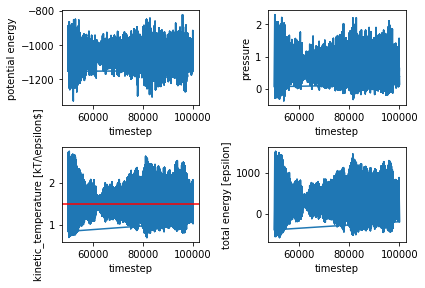

In [58]:
d = numpy.genfromtxt('log.txt',names = ['timestep','potential_energy','kinetic_energy','kinetic_temperature','pressure'],skip_header=1)

fig, ax = plt.subplots(2,2)


ax[0,0].plot(d['timestep'], d['potential_energy'])
ax[0,0].set_xlabel('timestep')
ax[0,0].set_ylabel('potential energy')

ax[1,0].plot(d['timestep'], d['kinetic_temperature'])
ax[1,0].set_xlabel('timestep')
ax[1,0].set_ylabel('kinetic_temperature [kT/\epsilon$]')
ax[1,0].axhline(y=kT, color='r', linestyle='-')

ax[0,1].plot(d['timestep'], d['pressure'])
ax[0,1].set_xlabel('timestep')
ax[0,1].set_ylabel('pressure')


ax[1,1].plot(d['timestep'], d['potential_energy']+d['kinetic_energy'])
ax[1,1].set_xlabel('timestep')
ax[1,1].set_ylabel('total energy [epsilon]')


plt.tight_layout()


The [NIST database](https://www.nist.gov/mml/csd/chemical-informatics-group/lennard-jones-fluid-properties) has a large compilation of LJ data for comparison. 

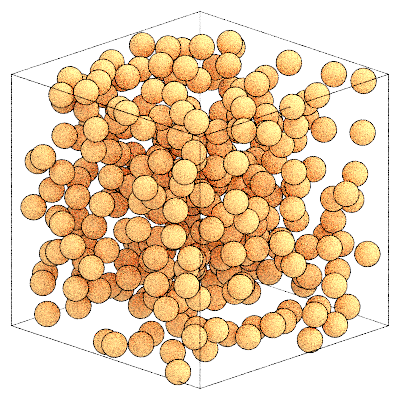

In [59]:
render_image(sim.state.get_snapshot())

Remove the table writers:

In [ ]:
sim.operations -= table
sim.operations -= table_file

## Logging array quantities

HOOMD-blue can log array quantities, such as the per particle energies `lj.energies`:

In [60]:
lj.energies[0:5]

array([-1.43966095, -1.70523321, -1.09024421, -1.29230884, -2.03036339])

However, `Table` does not write array quantities. Create a new logger that accepts `'scalar'` and `'particle'` categories:

In [61]:
array_logger =hoomd.logging.Logger(categories=['scalar','particle'])

Then add the per-particle quantity `energies` from `lj` to it:

In [62]:
array_logger += sim
array_logger.add(lj, quantities=['energies'])

Include the logged quantities in a GSD trajectory:

In [63]:
gsd_writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(100),
                             filename='trajectory.gsd',
                             logger=array_logger,
                             mode='wb')
sim.operations += gsd_writer

Run the simulation to generate the file:

In [64]:
sim.run(1000)

  101000     -1142.57335      915.05226          1.01672        0.06116  
  101000     -1142.57335      915.05226          1.01672        0.06116  


The values are available as numpy arrays:

In [65]:
with gsd.hoomd.open('trajectory.gsd', 'rb') as trajectory:
    for frame in trajectory:
        energies = frame.log['particles/md/pair/LJ/energies']
        print(energies.mean(), energies.std())

-1.735507042243846 0.6450328589187408
-1.5817688133444303 0.8174581132334068
-1.8255005456675364 0.6986545337559873
-1.8273787976027158 0.6747231407617218
-1.560369805007637 0.7385095406166033
-1.6083028955588667 0.6073568853443487
-1.862174788506319 0.6539310969435183
-1.6680563833401945 0.9065017451200758
-1.655333566588136 0.6890784930739279
-1.8240642054761527 0.7045681272449715


Map the potential energy to particle color:

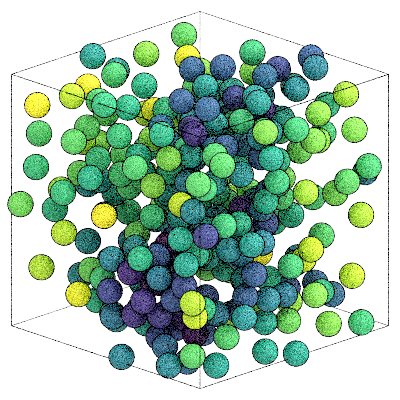

In [66]:
with gsd.hoomd.open('trajectory.gsd', 'rb') as trajectory:
    image = render_image(trajectory[-1])
image

In [67]:
del sim, thermo
del logger, array_logger, gsd_writer
del table_file
del integrator, nvt, lj, cell, cpu

# Introducing Polymers/Bonds

In this section, we are going to extend the tutorial to a system with bonds, i.e., a polymer. 

Here, we manually set the 10 particle positions:

In [68]:
snapshot = gsd.hoomd.Snapshot()

# Place a polymer in the box.
snapshot.particles.N = 10
snapshot.particles.position = [[-4, 0, 0],[-3, 0, 0],[-2, 0, 0], 
                               [-1, 0, 0], [0, 0, 0], [1, 0, 0],
                               [2, 0, 0],[3, 0, 0],[4, 0, 0],[5,0,0]]
snapshot.particles.types = ['A']
snapshot.particles.typeid = [0] * 10
snapshot.configuration.box = [20, 20, 20, 0, 0, 0]

Now we need to add bonds. See [Hoomd-blue Documentation](https://hoomd-blue.readthedocs.io/en/latest/module-md-bond.html#md-bond) for available bond potentials.


In [ ]:
# Connect particles with bonds.
snapshot.bonds.N = 9
snapshot.bonds.types = ['A-A']
snapshot.bonds.typeid = [0] * 9
snapshot.bonds.group = [[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [8,9]]

Render initial configuration (bonds not shown):

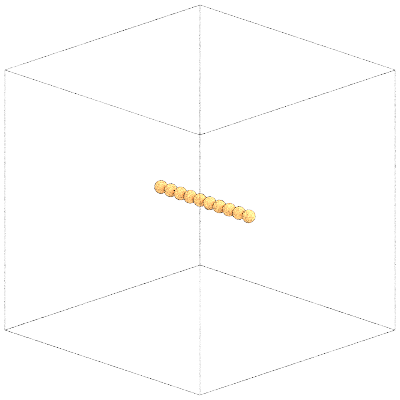

In [69]:
with gsd.hoomd.open(name='molecular_init.gsd', mode='wb') as f:
    f.append(snapshot)
render(snapshot)

We define [LJ pair](https://hoomd-blue.readthedocs.io/en/latest/module-md-pair.html#hoomd.md.pair.LJ) and [harmonic bond](https://hoomd-blue.readthedocs.io/en/latest/module-md-bond.html#hoomd.md.bond.Harmonic) interactions:

In [70]:
# Apply the harmonic potential on the bonds.
harmonic = hoomd.md.bond.Harmonic()
harmonic.params['A-A'] = dict(k=100, r0=1.0)

cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5

Define simulation (`hoomd.Simulation`), integrator (`hoomd.md.Integrator` with `hoomd.md.methods.NVT` and all forces (`lj` and `harmonic`), and gsd writer (`hoomd.write.GSD`): 

In [ ]:
sim = hoomd.Simulation(device=hoomd.device.CPU(), seed=1)
sim.create_state_from_gsd(filename='molecular_init.gsd')
nvt = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=1.5,tau=0.5)
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)
integrator = hoomd.md.Integrator(dt=0.005,
                                 methods=[nvt],
                                 forces=[harmonic,lj])
gsd_writer = hoomd.write.GSD(filename='molecular_trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(int(1e5)),
                             mode='wb')
sim.operations.integrator = integrator
sim.operations.writers.append(gsd_writer)

Run simulation for a million timesteps: 

In [76]:
sim.run(1e6)

Render movie:

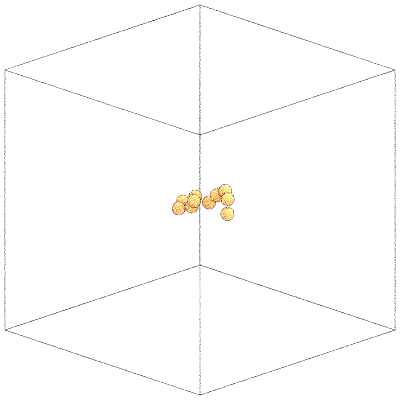

In [77]:
with gsd.hoomd.open('molecular_trajectory.gsd', 'rb') as trajectory:
    image = render_movie(trajectory)
image

In [ ]:
del sim
del gsd_writer
del integrator, nvt, harmonic, lj, cell

# Binary mixtures

simulation box (9.0, 9.0, 9.0, 0.0, 0.0, 0.0)
overall density 0.6858710562414266


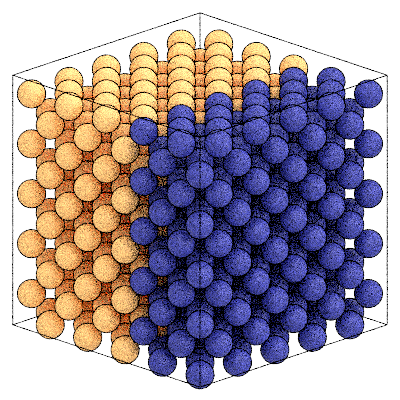

In [78]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=2)
snapshot = hoomd.Snapshot()
box, positions = freud.data.UnitCell.fcc().generate_system(num_replicas=5,
                                                           scale=1.8)
snapshot.particles.N = len(positions)
snapshot.particles.position[:] = positions
snapshot.particles.types = ['A','B']
snapshot.particles.typeid[:] = [0] * len(positions)
snapshot.particles.typeid[snapshot.particles.position[:,0]>0] = 1

snapshot.configuration.box = [box.Lx, box.Ly, box.Lz, 0, 0, 0]
sim.create_state_from_snapshot(snapshot)
print("simulation box", snapshot.configuration.box)
print("overall density", len(positions)/(box.Lx*box.Ly*box.Lz))
image = render_image(snapshot)
image

In [79]:
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5

lj.params[('B', 'A')] = dict(epsilon=0.4, sigma=1)
lj.r_cut[('B', 'A')] = 2.5

lj.params[('B', 'B')] = dict(epsilon=0.6, sigma=1)
lj.r_cut[('B', 'B')] = 2.5

all_particles = hoomd.filter.All()
thermo = hoomd.md.compute.ThermodynamicQuantities(filter=all_particles)
sim.operations += thermo
logger = hoomd.logging.Logger(categories=['scalar'])
logger.add(sim,quantities=['timestep'])
logger.add(thermo, quantities=['potential_energy','kinetic_energy','kinetic_temperature','pressure'])
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(1000),
                          logger=logger,
                          max_header_len=5,
                          max_precision=2)
sim.operations += table

In [80]:
nvt = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=0.4,tau=0.5)
integrator = hoomd.md.Integrator(dt=0.005,
                                 methods=[nvt],
                                 forces=[lj])
gsd_writer = hoomd.write.GSD(filename='binary_mixture_trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(int(1e3)),
                             mode='wb')
sim.operations.integrator = integrator
sim.operations.writers.append(gsd_writer)

In [81]:
sim.run(5e3)

 timestep  potential_energy kinetic_energy kinetic_temperature  pressure 
   1000      -2215.70069      313.18280          0.41841        0.69228  
   2000      -2378.11639      196.25778          0.26220        -1.03512 
   3000      -2174.09836      273.50796          0.36541        -0.60360 
   4000      -2208.19797      318.02064          0.42488        -0.30833 
   5000      -2213.19438      301.72458          0.40311        -0.35177 


In [82]:
with gsd.hoomd.open('phase_coexistence_trajectory.gsd', 'rb') as trajectory:
    image = render_movie(trajectory)
image

OSError: ignored